# Predicting the loan default risk of Czech bank customers using getML

### Introduction to relational learning with getML

This notebook demonstrates the application of our relational learning algorithm to predict if a customer of a bank will default on his loan. We train the predictor on customer metadata, transaction history, as well as other successful and unsuccessful loans.

Summary:

- Prediction type: __Binary classification__
- Domain: __Finance__
- Prediction target: __Loan default__
- Source data: __8 tables, 78.8 MB__
- Population size: __682__

_Author: Dr. Johannes King, Dr. Patrick Urbanke_

# Background

This notebook features a textbook example of predictive analytics applied to the financial sector. A loan is the lending of money to companies or individuals. Banks grant loans in exchange for the promise of repayment. Loan default is defined as the failure to meet this legal obligation, for example, when a home buyer fails to make a mortgage payment. A bank needs to estimate the risk it carries when granting loans to potentially non-performing customers.

The analysis is based on the [financial](https://relational.fit.cvut.cz/dataset/Financial) dataset from the [the CTU Prague Relational Learning Repository](https://arxiv.org/abs/1511.03086) (Motl and Schulte, 2015).

### A web frontend for getML

The getML monitor is a frontend built to support your work with getML. The getML monitor displays information such as the imported data frames, trained pipelines and allows easy data and feature exploration. You can launch the getML monitor [here](http://localhost:1709).

### Where is this running?

Your getML live session is running inside a docker container on [mybinder.org](https://mybinder.org/), a service built by the Jupyter community and funded by Google Cloud, OVH, GESIS Notebooks and the Turing Institute. As it is a free service, this session will shut down after 10 minutes of inactivity.

# Analysis

Let's get started with the analysis and set-up your session:

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Image, Markdown

plt.style.use("seaborn")
%matplotlib inline

import getml

print(f"getML API version: {getml.__version__}\n")

getml.engine.set_project("loans")

getML API version: 1.0.0




Connected to project 'loans'


## 1. Loading data


### 1.1 Download from source

Downloading the raw data from the CTU Prague Relational Learning Repository into a prediction ready format takes time. To get to the getML model building as fast as possible, we prepared the data for you and excluded the code from this notebook. It will be made available in a future version.

In [2]:
population_train, population_test, order, trans, meta = getml.datasets.load_loans()


Loading population_train...
[========================================] 100%

Loading population_test...
[========================================] 100%

Loading order...
[========================================] 100%

Loading trans...
[========================================] 100%

Loading meta...
[========================================] 100%


### 1.2 Prepare data for getML

The `getml.datasets.load_loans` method took care of the entire data lifting:
* Downloads csv's from our servers in python
* Converts csv's to getML [DataFrames]()
* Sets [roles]() to columns inside getML DataFrames

The only thing left is to set [units]() to columns that the relational learning algorithm is allowed to compare to each other.

__Data visualization__

To simplify the notebook, original data (image below) model is condensed into 4 tables, by resolving the trivial one-to-one and many-to-one joins:

- A population table *population_{train/test}*, consiting of `loan` and `account` tables
- Three peripheral tables: `order`, `trans`, and `meta`.
- Whereas `meta` is made up of `card`, `client`, `disp` and `district`

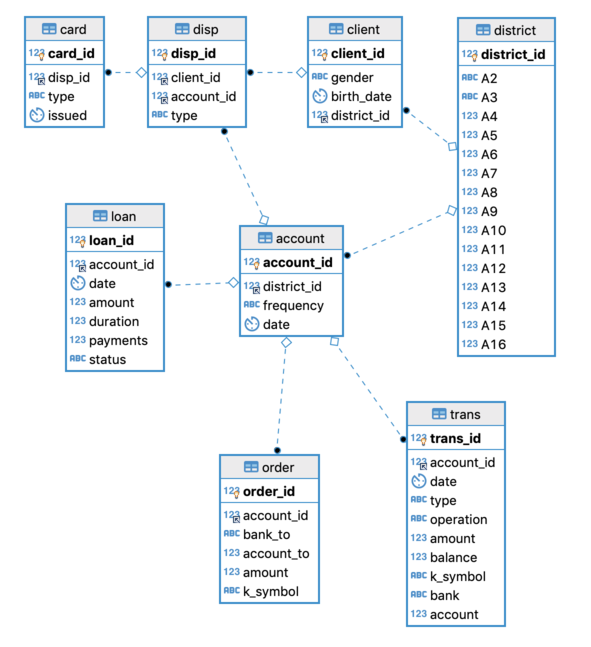

In [3]:
Image("assets/loans-schema.png", width=500)

#### Population table

- Information on the loan itself (duration, amount, date, ...)
- Geo-information about the branch where the loans was granted (A**)
- Column `status` contains binary target. Levels [A, C] := _loan paid back_ and [B, D] := _loan default_;
  we recoded status to our binary target: `default`

In [4]:
population_train

name,date,account_id,default,frequency,duration,payments,amount,loan_id,district_id,date_account,status
role,time_stamp,join_key,target,categorical,numerical,numerical,numerical,unused_float,unused_float,unused_float,unused_string
unit,time stamp,,,,,,money,,,,
0,1970-01-01 00:33:14,2,0,POPLATEK MESICNE,24,3373,80952,4959,1,1993,A
1,1970-01-01 00:33:17,25,0,POPLATEK MESICNE,12,2523,30276,4962,68,1996,A
2,1970-01-01 00:33:16,67,0,POPLATEK MESICNE,24,6915,165960,4973,16,1994,A
3,1970-01-01 00:33:17,103,1,POPLATEK MESICNE,36,7370,265320,4988,44,1996,D
4,1970-01-01 00:33:18,105,0,POPLATEK MESICNE,48,7348,352704,4989,21,1997,C
,...,...,...,...,...,...,...,...,...,...,...
454,1970-01-01 00:33:17,11271,0,POPLATEK MESICNE,36,1870,67320,7286,5,1995,C
455,1970-01-01 00:33:18,11327,0,POPLATEK MESICNE,24,1632,39168,7294,7,1997,C


#### Peripheral tables

- `meta`
  - Meta info about the client (card_type, gender, ...)
  - Geo-information about the client
- `order`
  - Permanent orders related to a loan (amount, balance, ...)
- `trans`
  - Transactions related to a given loan (amount, ...)

While the contents of `meta` and `order` are omitted for brevity, here are contents of `trans`:

In [5]:
trans

name,date,account_id,type,k_symbol,bank,operation,balance,amount,trans_id,account
role,time_stamp,join_key,categorical,categorical,categorical,categorical,numerical,numerical,unused_float,unused_string
unit,time stamp,,,,,,money,money,,
0,1970-01-01 00:33:15,1,PRIJEM,NULL,NULL,VKLAD,1000,1000,1,
1,1970-01-01 00:33:15,1,PRIJEM,NULL,AB,PREVOD Z UCTU,4679,3679,5,41403269
2,1970-01-01 00:33:15,1,PRIJEM,NULL,AB,PREVOD Z UCTU,20977,3679,6,41403269
3,1970-01-01 00:33:15,1,PRIJEM,NULL,AB,PREVOD Z UCTU,26835,3679,7,41403269
4,1970-01-01 00:33:15,1,PRIJEM,NULL,AB,PREVOD Z UCTU,30415,3679,8,41403269
,...,...,...,...,...,...,...,...,...,...
1056315,1970-01-01 00:33:18,10451,PRIJEM,UROK,NULL,NULL,17300,62,3682983,
1056316,1970-01-01 00:33:18,10451,PRIJEM,UROK,NULL,NULL,13442,49,3682984,


### 1.3 Define relational model

To start with relational learning, we need to specify an abstract data model. Here, we use the [high-level star schema API](https://docs.getml.com/latestapi/getml.data.StarSchema.html) that allows us to define the abstract data model and construct a [container](https://docs.getml.com/latest/api/getml.data.Container.html) with the concrete data at one-go. While a simple `StarSchema` indeed works in many cases, it is not sufficient for more complex data models like schoflake schemas, where you would have to define the data model and construct the container in separate steps, by utilzing getML's [full-fledged data model](https://docs.getml.com/latest/api/getml.data.DataModel.html) and [container](https://docs.getml.com/latest/api/getml.data.Container.html) APIs respectively.

In [6]:
star_schema = getml.data.StarSchema(
    train=population_train, test=population_test, alias="population"
)

star_schema.join(
    trans,
    on="account_id",
    time_stamps="date",
)

star_schema.join(
    order,
    on="account_id",
)

star_schema.join(
    meta,
    on="account_id",
)

star_schema

data model

  population:
    columns:
    - frequency: categorical
    - account_id: join_key
    - duration: numerical
    - payments: numerical
    - amount: numerical
    - ...

    joins:
    - right: 'trans'
      on: (population.account_id, trans.account_id)
      time_stamps: (population.date, trans.date)
      relationship: 'many-to-many'
      lagged_targets: False
    - right: 'order'
      on: (population.account_id, order.account_id)
      relationship: 'many-to-many'
      lagged_targets: False
    - right: 'meta'
      on: (population.account_id, meta.account_id)
      relationship: 'many-to-many'
      lagged_targets: False

  trans:
    columns:
    - type: categorical
    - k_symbol: categorical
    - bank: categorical
    - operation: categorical
    - account_id: join_key
    - ...

  order:
    columns:
    - bank_to: categorical
    - k_symbol: categorical
    - account_id: join_key
    - amount: numerical
    - order_id: unused_float
    - ...

  meta:
    columns:
    - type: categorical
    - gender: categorical
    - A3: categorical
    - account_id: join_key
    - A4: numerical
    - ...


container

  population
      subset   name               rows   type     
  0   train    population_train    459   DataFrame
  1   test     population_test     223   DataFrame

  peripheral
      name       rows   type     
  0   trans   1056320   DataFrame
  1   order      6471   DataFrame
  2   meta       5369   DataFrame

In [7]:
meta

name,account_id,type,gender,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16,disp_id,client_id,district_id,birth_date,card_id,issued,A2
role,join_key,categorical,categorical,categorical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,unused_float,unused_float,unused_float,unused_float,unused_string,unused_string,unused_string
0,1,OWNER,F,south Bohemia,70699,60,13,2,1,4,65.3,8968,2.8,3.35,131,1740,1910,1,1,18,1970,nan,nan,Pisek
1,2,OWNER,M,Prague,1204953,0,0,0,1,1,100,12541,0.2,0.43,167,85677,99107,2,2,1,1945,nan,nan,Hl.m. Praha
2,2,DISPONENT,F,Prague,1204953,0,0,0,1,1,100,12541,0.2,0.43,167,85677,99107,3,3,1,1940,nan,nan,Hl.m. Praha
3,3,OWNER,M,central Bohemia,95616,65,30,4,1,6,51.4,9307,3.8,4.43,118,2616,3040,4,4,5,1956,nan,nan,Kolin
4,3,DISPONENT,F,central Bohemia,95616,65,30,4,1,6,51.4,9307,3.8,4.43,118,2616,3040,5,5,5,1960,nan,nan,Kolin
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5364,11349,OWNER,F,Prague,1204953,0,0,0,1,1,100,12541,0.2,0.43,167,85677,99107,13647,13955,1,1945,nan,nan,Hl.m. Praha
5365,11349,DISPONENT,M,Prague,1204953,0,0,0,1,1,100,12541,0.2,0.43,167,85677,99107,13648,13956,1,1943,nan,nan,Hl.m. Praha
5366,11359,OWNER,M,south Moravia,117897,139,28,5,1,6,53.8,8814,4.7,5.74,107,2112,2059,13660,13968,61,1968,1247.000000,1995.000000,Trebic


## 2. Predictive modeling

We loaded the data, defined the roles, units and the abstract data model. Next, we create a getML pipeline for relational learning.

### 2.1 getML Pipeline

<!-- #### 2.1.1  -->
__Set-up of feature learners, selectors & predictor__

In [8]:
mapping = getml.preprocessors.Mapping(min_freq=100)

fast_prop = getml.feature_learning.FastProp(
    aggregation=getml.feature_learning.FastProp.agg_sets.All,
    loss_function=getml.feature_learning.loss_functions.CrossEntropyLoss,
    num_threads=1,
)

feature_selector = getml.predictors.XGBoostClassifier(n_jobs=1)

# the population is really small, so we set gamma and reg_lambda to mitigate overfitting
predictor = getml.predictors.XGBoostClassifier(gamma=2, n_jobs=1, reg_lambda=50)

__Build the pipeline__

In [9]:
pipe = getml.pipeline.Pipeline(
    data_model=star_schema.data_model,
    preprocessors=[mapping],
    feature_learners=[fast_prop],
    feature_selectors=[feature_selector],
    predictors=predictor,
)

### 2.2 Model training

In [10]:
pipe.fit(star_schema.train)

Checking data model...


Staging...
[========================================] 100%

Preprocessing...
[========================================] 100%

Checking...
[========================================] 100%


OK.


Staging...
[========================================] 100%

Preprocessing...
[========================================] 100%

FastProp: Trying 874 features...
[========================================] 100%

FastProp: Building features...
[========================================] 100%

XGBoost: Training as feature selector...
[========================================] 100%

XGBoost: Training as predictor...
[========================================] 100%


Trained pipeline.
Time taken: 0h:0m:2.618372



Pipeline(data_model='population',
         feature_learners=['FastProp'],
         feature_selectors=['XGBoostClassifier'],
         include_categorical=False,
         loss_function=None,
         peripheral=['meta', 'order', 'trans'],
         predictors=['XGBoostClassifier'],
         preprocessors=['Mapping'],
         share_selected_features=0.5,
         tags=['container-ipKKtL'])

url: http://localhost:1709/#/getpipeline/loans/FrSUiG/0/

### 2.3 Model evaluation

In [11]:
pipe.score(star_schema.test)



Staging...
[========================================] 100%

Preprocessing...
[========================================] 100%

FastProp: Building features...
[========================================] 100%




,date time,set used,target,accuracy,auc,cross entropy
0,2021-08-23 23:33:21,train,default,0.963,0.9607,0.1677
1,2021-08-23 23:33:22,test,default,0.9776,0.9809,0.1328


### 2.4 Studying features

__Visualizing the learned features__

The feature with the highest importance is:

In [12]:
by_importances = pipe.features.sort(by="importances")
by_importances[0].sql

```sql
DROP TABLE IF EXISTS "FEATURE_1_6";

CREATE TABLE "FEATURE_1_6" AS
SELECT MIN( t2."balance" ) AS "feature_1_6",
       t1.rowid AS "rownum"
FROM "POPULATION__STAGING_TABLE_1" t1
LEFT JOIN "TRANS__STAGING_TABLE_4" t2
ON t1."account_id" = t2."account_id"
WHERE t2."date" <= t1."date"
GROUP BY t1.rowid;
```

__Feature correlations__

We want to analyze how the features are correlated with the target variable.

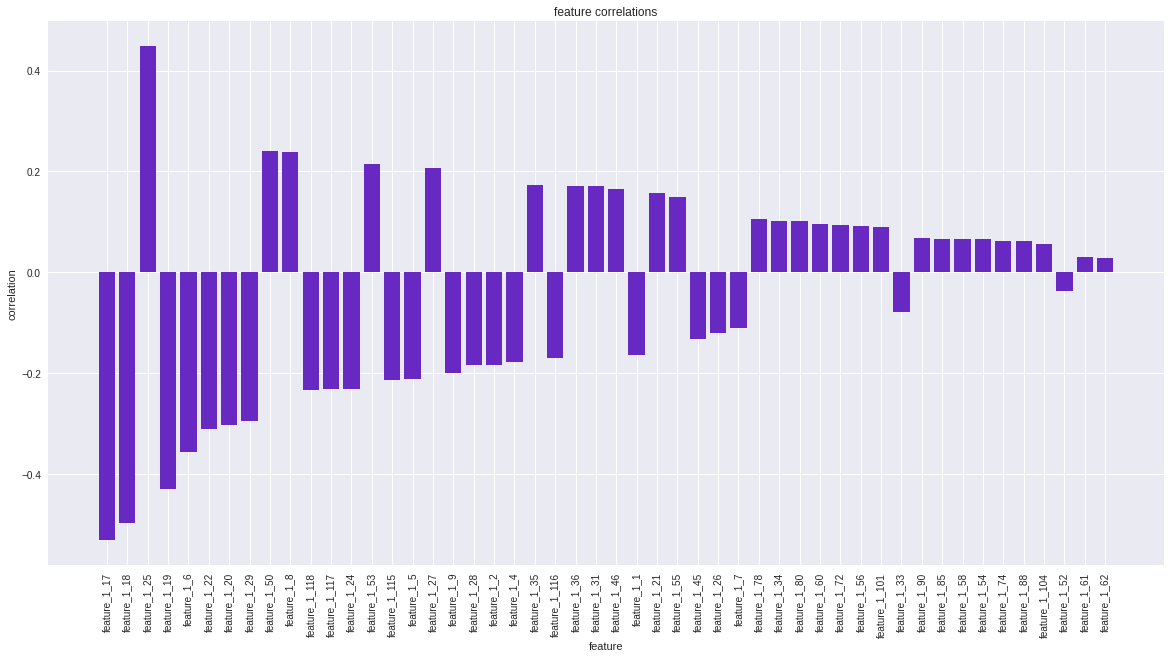

In [13]:
names, correlations = pipe.features[:50].correlations()

fig, ax = plt.subplots(figsize=(20, 10))

ax.bar(names, correlations, color="#6829c2")

ax.set_title("feature correlations")
ax.set_xlabel("feature")
ax.set_ylabel("correlation")
ax.tick_params(axis="x", rotation=90)

__Feature importances__

Feature importances are calculated by analyzing the improvement in predictive accuracy on each node of the trees in the XGBoost predictor. They are then normalized, so that all importances add up to 100%.

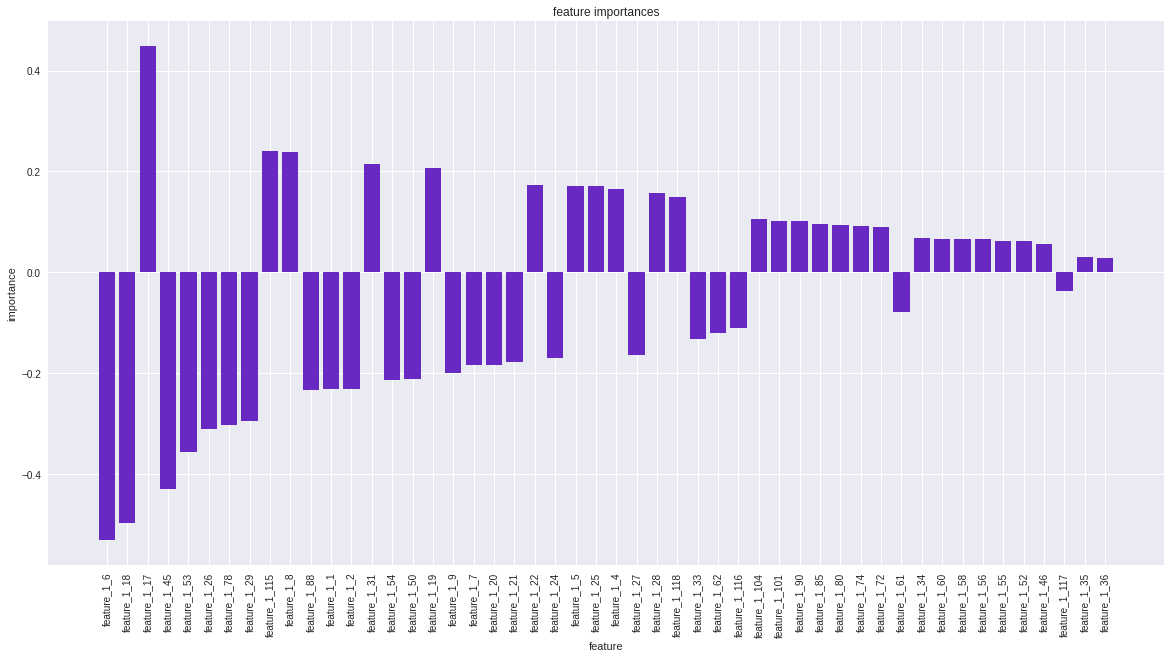

In [14]:
names, importances = pipe.features[:50].importances()

fig, ax = plt.subplots(figsize=(20, 10))

ax.bar(names, correlations, color="#6829c2")

ax.set_title("feature importances")
ax.set_xlabel("feature")
ax.set_ylabel("importance")
ax.tick_params(axis="x", rotation=90)

__Column importances__

Because getML uses relational learning, we can apply the principles we used to calculate the feature importances to individual columns as well.

As we can see, a lot of the predictive power stems from the account balance. This is unsurprising: People with less money on their bank accounts are more likely to default on their loans.

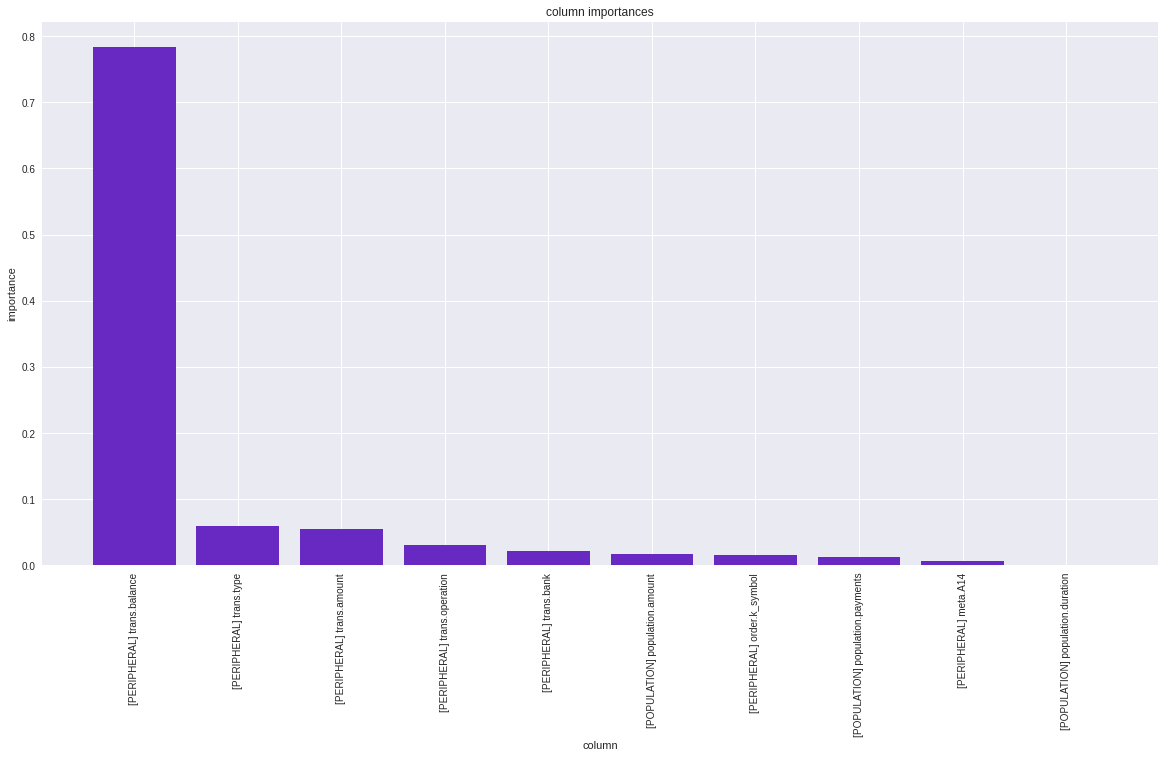

In [15]:
names, importances = pipe.columns.importances()

fig, ax = plt.subplots(figsize=(20, 10))

ax.bar(names, importances, color="#6829c2")

ax.set_title("column importances")
ax.set_xlabel("column")
ax.set_ylabel("importance")
ax.tick_params(axis="x", rotation=90)

### 2.5 Productionization

It is possible to productionize the pipeline by transpiling the features into production-ready SQL code. Please also refer to getML's `sqlite3` module.

In [16]:
# Creates a folder named loans_pipeline containing
# the SQL code.
pipe.features.to_sql().save("loans_pipeline")

## 3. Conclusion

By applying getML to the PKDD'99 Financial dataset, we were able to show the power and relevance of Relational Learning on a real-world data set. Within a training time below 1 minute, we outperformed almost all approaches based on manually generated features. This makes getML the prime choice when dealing with complex relational data schemes. This result holds independent of the problem domain since no expertise in the financial sector was used in this analysis.

The present analysis could be improved in two directions. By performing an extensive hyperparameter optimization, the out of sample AUC could be further improved. On the other hand, the hyperparameters could be tuned to produce less complex features that result in worse performance (in terms of AUC) but are better interpretable by humans.

 ## References

Schulte, Oliver, et al. "A hierarchy of independence assumptions for multi-relational Bayes net classifiers." 2013 IEEE Symposium on Computational Intelligence and Data Mining (CIDM). IEEE, 2013.

# Next Steps

This tutorial went through the basics of applying getML to relational data.

If you are interested in further real-world applications of getML, head back to the [notebook overview](welcome.md) and choose one of the remaining examples.

Here is some additional material from our [documentation](https://docs.getml.com/latest/) if you want to learn more about getML:
* [Feature learning with Multirel](https://docs.getml.com/latest/user_guide/feature_engineering/feature_engineering.html#multirel)
* [Feature learning with Relboost](https://docs.getml.com/latest/user_guide/feature_engineering/feature_engineering.html#relboost)

# Get in contact

If you have any question schedule a [call with Alex](https://go.getml.com/meetings/alexander-uhlig/getml-demo), the co-founder of getML, or write us an [email](team@getml.com). Prefer a private demo of getML? Just contact us to make an appointment.